<a href="https://colab.research.google.com/github/jhordi19/Ciencia_de_datos/blob/Taller/Taller_Sem07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Valoración de Riesgo de Hipertensión Modelo ML**

El dataset fue sacado de Kaggle el cual tiene el nombre de
[Hypertension Risk Prediction Dataset](https://www.kaggle.com/datasets/ankushpanday1/hypertension-risk-prediction-dataset/datahttps://)

✅ Instalación de Librerías Necesarias

In [ ]:
!pip install imbalanced-learn
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 3.4 MB/s eta 0:00:00


📚 Importar Librerías autilizar

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from scipy.stats import randint,  uniform
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from imblearn.combine import SMOTEENN
from sklearn.compose import ColumnTransformer

--------------------------------------------------------------------------

##🧩 1. Cargamos el Dataset

In [ ]:
df = pd.read_csv("hypertension_dataset.csv")

Identificamos la dimension del dataset

In [ ]:
df.shape

(174982, 23)

Seleccionamos las Columnas a utilizar

In [ ]:
cols = ['Gender', 'Age', 'BMI', 'Physical_Activity_Level', 'Sleep_Duration',
        'Smoking_Status', 'Salt_Intake', 'Alcohol_Intake', 'Family_History', 'Stress_Level', 'Hypertension']
df = df[cols].copy()

--------------------------------------------------------------------------

##🧪 2. Preprocesamiento de Datos

Se codifican las variables categóricas y se escalan los datos numéricos.

In [ ]:
df['Hypertension'] = df['Hypertension'].map({'High': 1, 'Low': 0})

# 3. Mapear binarios
df['Family_History'] = df['Family_History'].map({'No': 0, 'Yes': 1})

# 4. Discretizar
def bin_alcohol(x):
    if x == 0:
        return 'None'
    elif x <= 10:
        return 'Low'
    elif x <= 20:
        return 'Moderate'
    else:
        return 'High'

def bin_salt(x):
    if x < 5:
        return 'Low'
    elif x <= 10:
        return 'Moderate'
    else:
        return 'High'

df['Alcohol_Level'] = df['Alcohol_Intake'].apply(bin_alcohol)
df['Salt_Level'] = df['Salt_Intake'].apply(bin_salt)

# 5. Definir X e y
X = df.drop(['Hypertension', 'Alcohol_Intake', 'Salt_Intake'], axis=1)
y = df['Hypertension']

# 6. Columnas por tipo
numeric_cols = ['Age', 'BMI', 'Sleep_Duration']
ordinal_cols = ['Smoking_Status', 'Physical_Activity_Level', 'Stress_Level', 'Alcohol_Level', 'Salt_Level']
ordinal_map = [
    ['Never', 'Former', 'Current'],
    ['Low', 'Moderate', 'High'],
    list(range(1, 10)),
    ['None', 'Low', 'Moderate', 'High'],
    ['Low', 'Moderate', 'High']
]
binary_cols = ['Family_History']
nominal_cols = ['Gender']

# 7. Preprocesamiento
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('ord', OrdinalEncoder(categories=ordinal_map), ordinal_cols),
    ('bin', 'passthrough', binary_cols),
    ('nom', OneHotEncoder(drop='first'), nominal_cols)
])

# 8. Aplicar preprocesamiento
X_preprocessed = preprocessor.fit_transform(X)

Verificamos el tipo de dato

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174982 entries, 0 to 174981
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Gender                   174982 non-null  object 
 1   Age                      174982 non-null  int64  
 2   BMI                      174982 non-null  float64
 3   Physical_Activity_Level  174982 non-null  object 
 4   Sleep_Duration           174982 non-null  float64
 5   Smoking_Status           174982 non-null  object 
 6   Salt_Intake              174982 non-null  float64
 7   Alcohol_Intake           174982 non-null  float64
 8   Family_History           174982 non-null  int64  
 9   Stress_Level             174982 non-null  int64  
 10  Hypertension             174982 non-null  int64  
 11  Alcohol_Level            174982 non-null  object 
 12  Salt_Level               174982 non-null  object 
dtypes: float64(4), int64(4), object(5)
memory usage: 17.4+ MB


Verificamos si tiene nulos

In [ ]:
print("Valores nulos por columna:")
print(df.isnull().sum())

Valores nulos por columna:
Gender                     0
Age                        0
BMI                        0
Physical_Activity_Level    0
Sleep_Duration             0
Smoking_Status             0
Salt_Intake                0
Alcohol_Intake             0
Family_History             0
Stress_Level               0
Hypertension               0
Alcohol_Level              0
Salt_Level                 0
dtype: int64


--------------------------------------------------------------------------

## ⚙ 3. Análisis Exploratorio - PCA y Clustering

🔹 Se realiza un PCA para visualizar la distribución de datos y un clustering con KMeans.

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_preprocessed)

📌 Gráficamos la Distribución

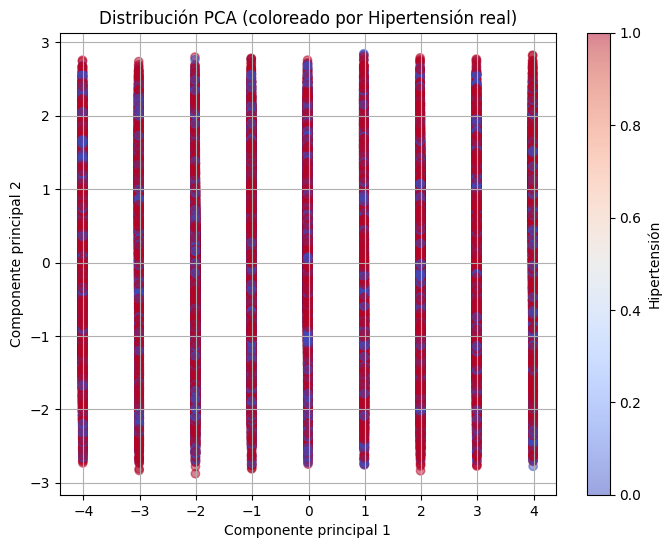

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.title("Distribución PCA (coloreado por Hipertensión real)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.colorbar(label='Hipertensión')
plt.grid(True)
plt.show()

🔹 KMeans clustering sobre datos escalados

In [ ]:
kmeans = KMeans(n_clusters=11, random_state=42)
kmeans_labels = kmeans.fit_predict(X_preprocessed)

📌 Gráfico Clustering (según KMeans)

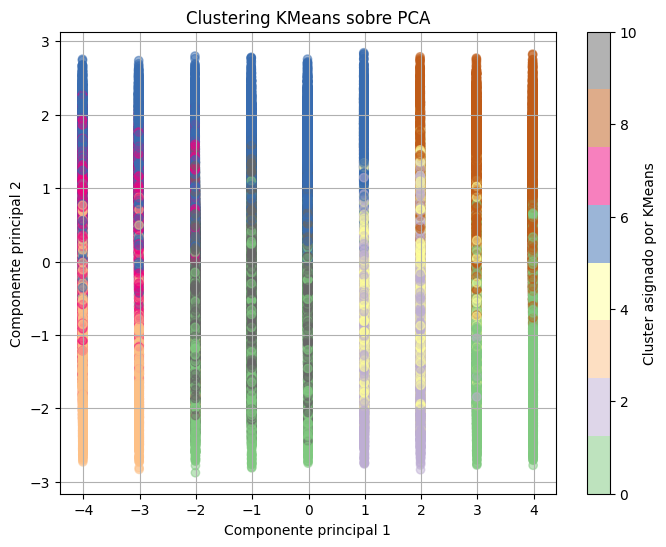

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='Accent', alpha=0.5)
plt.title("Clustering KMeans sobre PCA")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.colorbar(label='Cluster asignado por KMeans')
plt.grid(True)
plt.show()

🔹 Clustering jerárquico (solo para dendrograma)

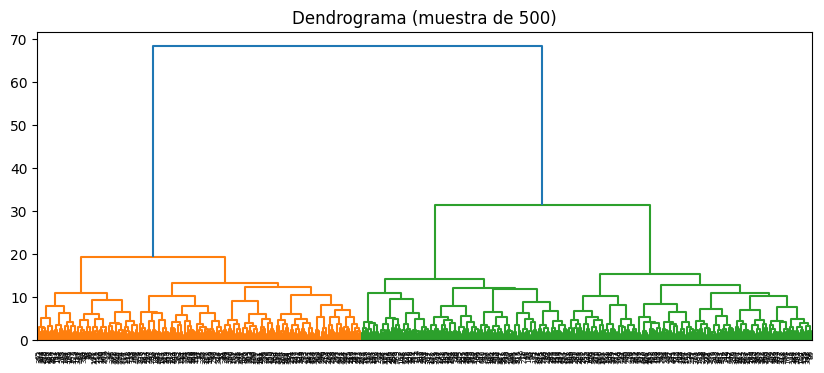

In [ ]:
linkage_matrix = linkage(X_preprocessed[:500], method='ward')
plt.figure(figsize=(10, 4))
dendrogram(linkage_matrix)
plt.title("Dendrograma (muestra de 500)")
plt.show()

## ⚖️ 4. Balanceo con SMOTE

Aplicamos SMOTE para poder balancear las clases minoritarias.

In [ ]:
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_preprocessed, y)

Dividimos la clase train y test

In [ ]:
# 10. División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

## 🤖 5. Entrenamiento de Modelos

###5.1 Random Forest

Se entrena un Random Forest con búsqueda aleatoria de hiperparámetros.

🔍 RANDOM SEARCH - Establecemos los Hiperparámetros

In [ ]:
param_dist = {
    'n_estimators': randint(100, 200),
    'max_depth': [20, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=10,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)


🚀 ENTRENAMIENTO

In [ ]:
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


 ## 6. 🧾 EVALUACIÓN


Visualización de métricas Clásicas y creación de curva ROC

In [ ]:
y_pred = best_model.predict(X_test)
print("✅ Mejores parámetros:", random_search.best_params_)
print("\n✅ Accuracy en validación cruzada:", random_search.best_score_)
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred))
print("✅ Accuracy en test:", accuracy_score(y_test, y_pred))
print("✅ Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

✅ Mejores parámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 188}

✅ Accuracy en validación cruzada: 0.835152015803294

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91     13935
           1       0.86      0.82      0.84      8753

    accuracy                           0.88     22688
   macro avg       0.88      0.87      0.87     22688
weighted avg       0.88      0.88      0.88     22688

✅ Accuracy en test: 0.8824047954866009
✅ Matriz de confusión:
 [[12809  1126]
 [ 1542  7211]]


In [ ]:
import pandas as pd

# Datos del paciente
nuevo_paciente = pd.DataFrame([{
    'Gender': 'Male',
    'Age': 35,
    'BMI': 26.8,
    'Physical_Activity_Level': 'Moderate',
    'Sleep_Duration': 7.0,
    'Smoking_Status': 'Never',
    'Family_History': 1,
    'Stress_Level': 6,
    'Alcohol_Level': 'Moderate',  # ⬅️ Agregado
    'Salt_Level': 'High'          # ⬅️ Agregado
}])

# Transformar con el preprocesador
X_nuevo_preprocesado = preprocessor.transform(nuevo_paciente)

# Predicción con el modelo Random Forest entrenado
prediccion = best_model.predict(X_nuevo_preprocesado)[0]
probabilidad = best_model.predict_proba(X_nuevo_preprocesado)[0][1]

# Mostrar resultado
print("=== RESULTADO ===")
if prediccion == 1:
    print(f"✅ Riesgo ALTO de hipertensión con {probabilidad*100:.2f}% de probabilidad")
else:
    print(f"🟢 Riesgo BAJO de hipertensión con {(1-probabilidad)*100:.2f}% de probabilidad")


=== RESULTADO ===
✅ Riesgo ALTO de hipertensión con 61.26% de probabilidad


In [ ]:
import joblib
from sklearn.pipeline import Pipeline

modelo_completo = Pipeline([
    ('preprocesamiento', preprocessor),
    ('clasificador', best_model)
])

modelo_completo.fit(X, y)

# Guardar con compresión nivel 3 (nivel recomendado)
joblib.dump(modelo_completo, 'Random_F.pkl', compress=9)

print("✅ Modelo exportado como 'Random_F.pkl' con compresión nivel 3")


✅ Modelo exportado como 'Random_F.pkl' con compresión nivel 3


In [ ]:
# Paso 1: Aplica SMOTEENN dentro del pipeline completo
from imblearn.pipeline import Pipeline as ImbPipeline

modelo_completo = ImbPipeline([
    ('preprocesamiento', preprocessor),
    ('balanceo', SMOTEENN(random_state=42)),  # Agregas el resampling
    ('clasificador', best_model)
])

# Paso 2: Entrena con X (dataframe original) y y
modelo_completo.fit(X, y)

# Paso 3: Exporta
import joblib
joblib.dump(modelo_completo, 'modelo_random_forest_pipeline.pkl', compress=9)
print("✅ Modelo exportado correctamente con preprocesamiento + SMOTEENN + modelo")


✅ Modelo exportado correctamente con preprocesamiento + SMOTEENN + modelo


In [ ]:
from sklearn.pipeline import Pipeline

# Crear el pipeline con preprocessor + mejor modelo
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('modelo', random_search.best_estimator_)
])

# Entrenar el pipeline completo
pipeline_rf.fit(X, y)

# Exportar pipeline completo
import joblib
joblib.dump(pipeline_rf, "rf_model.pkl", compress=9)

print("✅ Pipeline (preprocesamiento + modelo) guardado como rf_model.pkl")

✅ Pipeline (preprocesamiento + modelo) guardado como rf_model.pkl


📈 Visualización de Curva ROC

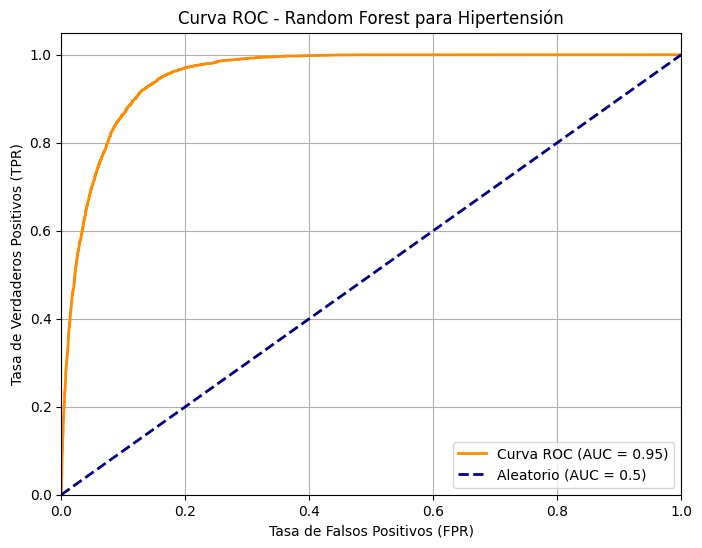

In [ ]:
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatorio (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Random Forest para Hipertensión')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 🚀 5.2. Decision Tree

Aplicamos RandomizedSearchCV para la búsqueda de los mejores hiperparámetros, aplicando 10 folds y 15 iteraciones, dando un total de 150 fits

In [ ]:
# 🔍 Hiperparámetros para Decision Tree
param_dist = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [None, "sqrt", "log2"]
}

# 🎯 Entrenamiento con búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=15,
    cv=10,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)
best_dt = random_search.best_estimator_

# 📊 Evaluación
y_pred_dt = best_dt.predict(X_test)
print("✅ Mejores parámetros:", random_search.best_params_)
print("✅ Accuracy en test:", accuracy_score(y_test, y_pred_dt))
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred_dt))
print("✅ Matriz de confusión:\n", confusion_matrix(y_test, y_pred_dt))

Fitting 10 folds for each of 15 candidates, totalling 150 fits
✅ Mejores parámetros: {'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': None, 'criterion': 'entropy'}
✅ Accuracy en test: 0.7514985895627645

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.80     13935
           1       0.69      0.65      0.67      8753

    accuracy                           0.75     22688
   macro avg       0.74      0.73      0.73     22688
weighted avg       0.75      0.75      0.75     22688

✅ Matriz de confusión:
 [[11372  2563]
 [ 3075  5678]]


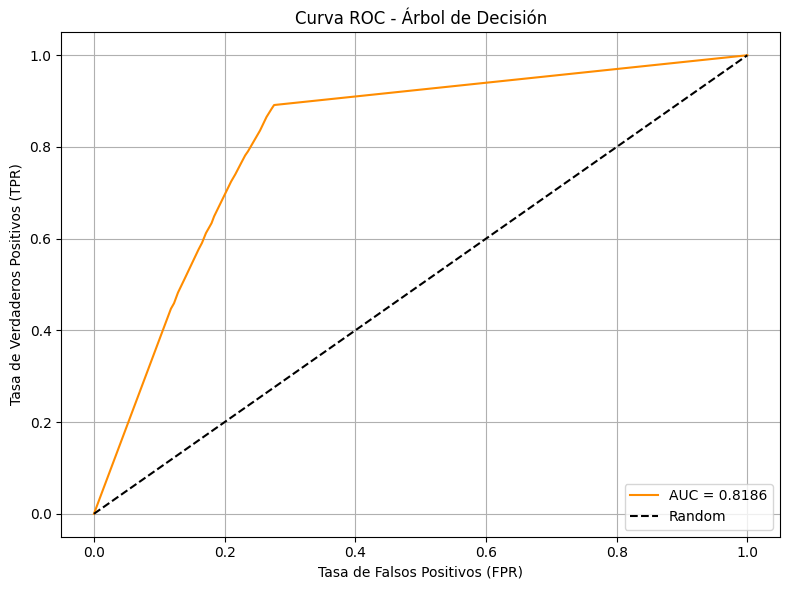

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Obtener probabilidades para la clase positiva (1)
y_probs = best_dt.predict_proba(X_test)[:, 1]

# Calcular puntos de la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Árbol de Decisión")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import joblib
from sklearn.pipeline import Pipeline

modelo_completo = Pipeline([
    ('preprocesamiento', preprocessor),
    ('clasificador', best_dt)
])

modelo_completo.fit(X, y)

# Guardar con compresión nivel 3 (nivel recomendado)
joblib.dump(modelo_completo, 'Decision_T.pkl', compress=9)

print("✅ Modelo exportado como 'Decision_T.pkl' con compresión nivel 3")


✅ Modelo exportado como 'Decision_T.pkl' con compresión nivel 3


In [ ]:
from sklearn.pipeline import Pipeline
import joblib

# Crear pipeline con el preprocesamiento y el modelo de árbol de decisión
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('modelo', best_model)
])

# Entrenar el pipeline completo con X original
pipeline_dt.fit(X, y)

# Exportar el pipeline como archivo .pkl
joblib.dump(pipeline_dt, "dt_model.pkl")

print("✅ Pipeline Decision Tree exportado como dt_model.pkl")

✅ Pipeline Decision Tree exportado como dt_model.pkl


## 🚀 5.3. XGBoost

Aplicamos RandomizedSearchCV para la búsqueda de los mejores hiperparámetros, aplicando 10 folds y 10 iteraciones, dando un total de 100 fits

In [ ]:
qfrom sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# 🔍 Hiperparámetros para XGBoost
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [3, 5, 7, 10],
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 5)
}

# Búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=10,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Entrenamiento
random_search.fit(X_train, y_train)
best_xg = random_search.best_estimator_

# 📊 EVALUACIÓN
y_pred_xgb = best_xg.predict(X_test)
print("✅ Mejores parámetros:", random_search.best_params_)
print("✅ Accuracy en test:", accuracy_score(y_test, y_pred_xgb))
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("✅ Matriz de confusión:\n", confusion_matrix(y_test, y_pred_xgb))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:55:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Mejores parámetros: {'colsample_bytree': np.float64(0.7541666010159664), 'gamma': np.float64(0.07983126110107097), 'learning_rate': np.float64(0.0792681476866447), 'max_depth': 10, 'n_estimators': 210, 'subsample': np.float64(0.8733054075301833)}
✅ Accuracy en test: 0.8054478138222849

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.76      0.83     13935
           1       0.70      0.87      0.78      8753

    accuracy                           0.81     22688
   macro avg       0.80      0.82      0.80     22688
weighted avg       0.83      0.81      0.81     22688

✅ Matriz de confusión:
 [[10634  3301]
 [ 1113  7640]]


📈 Visualización de Curva ROC

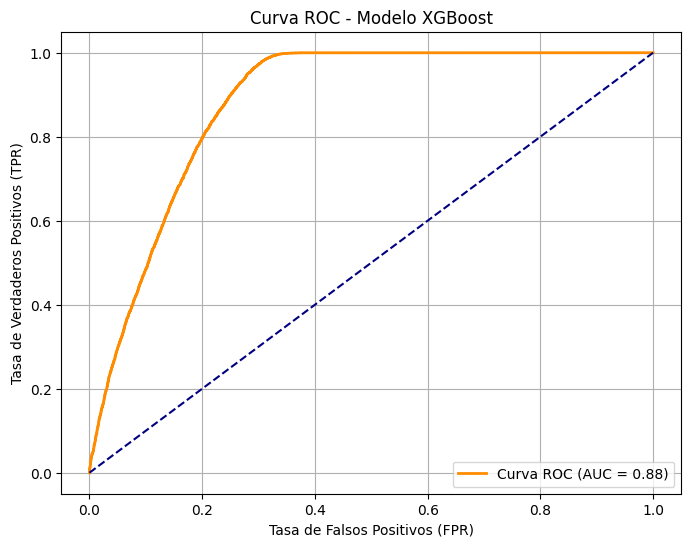

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# CURVA ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtener probabilidades de clase positiva
y_proba = best_model.predict_proba(X_test)[:, 1]

# Calcular FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr,tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("Curva ROC - Modelo XGBoost")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.grid(True)
plt.legend()
plt.show()

Calculamos la métrica para cada umbral y verificamos cual es el más óptimo

    Umbral  Precision    Recall  F1-Score
0     0.10   0.536336  1.000000  0.698201
1     0.15   0.570079  1.000000  0.726179
2     0.20   0.594431  1.000000  0.745634
3     0.25   0.616408  1.000000  0.762689
4     0.30   0.633749  0.999315  0.775615
5     0.35   0.648366  0.997030  0.785756
6     0.40   0.661969  0.987319  0.792553
7     0.45   0.677310  0.954873  0.792490
8     0.50   0.698291  0.872844  0.775871
9     0.55   0.723717  0.725123  0.724419
10    0.60   0.748875  0.532503  0.622421
11    0.65   0.778437  0.344796  0.477910
12    0.70   0.805752  0.195247  0.314328
13    0.75   0.823045  0.091397  0.164524
14    0.80   0.872881  0.035302  0.067860
15    0.85   0.944444  0.009711  0.019224
16    0.90   1.000000  0.000685  0.001370


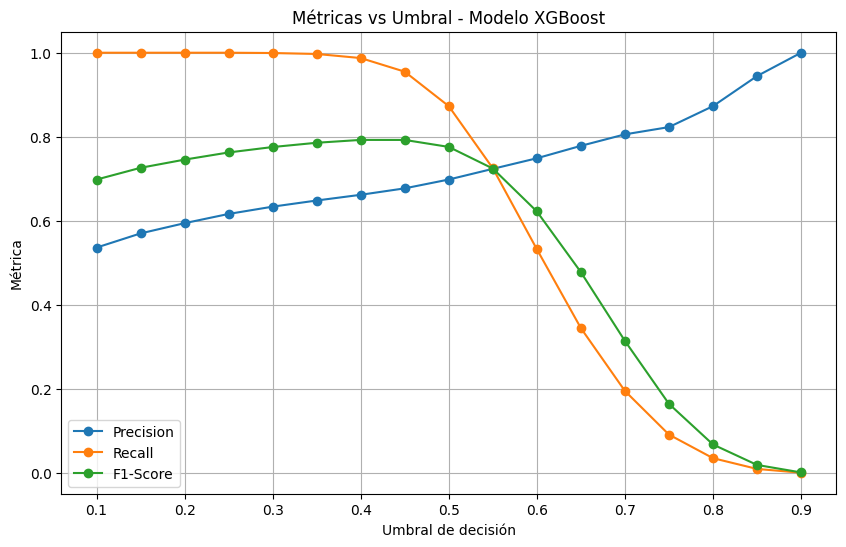

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Obtener probabilidades del modelo
y_proba = best_xg.predict_proba(X_test)[:, 1]

# Definir lista de umbrales a evaluar
umbrales = np.arange(0.1, 0.91, 0.05)
resultados = []

# Calcular métricas para cada umbral
for u in umbrales:
    y_pred_u = (y_proba >= u).astype(int)
    precision = precision_score(y_test, y_pred_u)
    recall = recall_score(y_test, y_pred_u)
    f1 = f1_score(y_test, y_pred_u)
    resultados.append([u, precision, recall, f1])

# Crear DataFrame
df_resultados = pd.DataFrame(resultados, columns=['Umbral', 'Precision', 'Recall', 'F1-Score'])

# Mostrar tabla
print(df_resultados)

# Visualizar gráficamente
plt.figure(figsize=(10, 6))
plt.plot(df_resultados['Umbral'], df_resultados['Precision'], label='Precision', marker='o')
plt.plot(df_resultados['Umbral'], df_resultados['Recall'], label='Recall', marker='o')
plt.plot(df_resultados['Umbral'], df_resultados['F1-Score'], label='F1-Score', marker='o')
plt.xlabel("Umbral de decisión")
plt.ylabel("Métrica")
plt.title("Métricas vs Umbral - Modelo XGBoost")
plt.grid(True)
plt.legend()
plt.show()


Observando el Gráfico, el umbral quenos brinda resultados más balanceados es el 0.4

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 🔹 Obtener probabilidades
y_proba = best_xg.predict_proba(X_test)[:, 1]

# 🔹 Aplicar nuevo umbral
nuevo_umbral = 0.55
y_pred_xgb_ajustado = (y_proba >= nuevo_umbral).astype(int)

# 🔹 Evaluar con nuevo umbral
print(f"✅ Resultados con umbral ajustado a {nuevo_umbral}:\n")
print("🔸 Accuracy:", accuracy_score(y_test, y_pred_xgb_ajustado))
print("🔸 Classification Report:\n", classification_report(y_test, y_pred_xgb_ajustado))
print("🔸 Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_xgb_ajustado))


✅ Resultados con umbral ajustado a 0.55:

🔸 Accuracy: 0.7871562059238364
🔸 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83     13935
           1       0.72      0.73      0.72      8753

    accuracy                           0.79     22688
   macro avg       0.78      0.78      0.78     22688
weighted avg       0.79      0.79      0.79     22688

🔸 Matriz de Confusión:
 [[11512  2423]
 [ 2406  6347]]


In [ ]:
import joblib
from sklearn.pipeline import Pipeline

# 🛠️ Combinar preprocesador y modelo XGBoost en un Pipeline
modelo_xgb_completo = Pipeline([
    ('preprocesamiento', preprocessor),  # Asegúrate de que ya esté definido en tu notebook
    ('clasificador', best_xg)
])

# ✅ Entrenar el pipeline completo con todos los datos
modelo_xgb_completo.fit(X, y)

# 💾 Exportar como archivo comprimido
joblib.dump(modelo_xgb_completo, 'XGBoost.pkl', compress=9)
print("✅ Modelo XGBoost exportado como 'XGBoost.pkl'")


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:56:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Modelo XGBoost exportado como 'XGBoost.pkl'


## 📊 7. Comparación de Modelos desarrollados

Finalmente realizamos un gráfico comparando las métricas de los modelos desarrollados observando:
- Accuracy
- Precision
- Recall
- F1-Score

📊 Métricas comparadas:


,Accuracy,Precision,Recall,F1-Score
Random Forest,0.882405,0.881899,0.882405,0.881838
Decision Tree,0.751499,0.749283,0.751499,0.749997
XGBoost,0.787156,0.787234,0.787156,0.787194


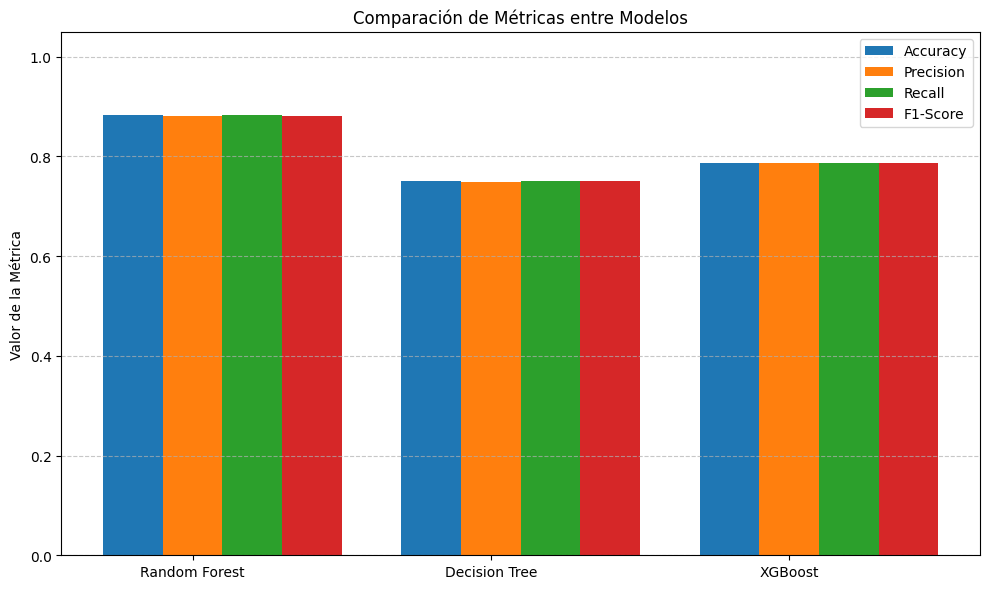

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

# Calcular métricas para cada modelo
metricas = {
    "Random Forest": {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred, average='weighted')
    },
    "Decision Tree": {
        "Accuracy": accuracy_score(y_test, y_pred_dt),
        "Precision": precision_score(y_test, y_pred_dt, average='weighted'),
        "Recall": recall_score(y_test, y_pred_dt, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred_dt, average='weighted')
    },
    "XGBoost": {
        "Accuracy": accuracy_score(y_test, y_pred_xgb_ajustado),
        "Precision": precision_score(y_test, y_pred_xgb_ajustado, average='weighted'),
        "Recall": recall_score(y_test, y_pred_xgb_ajustado, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred_xgb_ajustado, average='weighted')
    }
}

# Crear DataFrame
df_metricas = pd.DataFrame(metricas).T

# Mostramos las métricas
print("📊 Métricas comparadas:")
display(df_metricas)

# Creamos el gráfico de barras agrupadas
labels = df_metricas.index
metricas_names = df_metricas.columns
x = np.arange(len(labels))
width = 0.2

plt.figure(figsize=(10, 6))
for i, metrica in enumerate(metricas_names):
    plt.bar(x + i * width, df_metricas[metrica], width=width, label=metrica)

plt.xticks(x + width, labels)
plt.ylim(0, 1.05)
plt.ylabel("Valor de la Métrica")
plt.title("Comparación de Métricas entre Modelos")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
